# Manipulation of cooler files
Sometimes it is necessary to change the data stored in a cooler file. Perhaps, you want to remove coms chromosomes, rename them, or completely rearrange them.

Here we are collecting some examples of how to do some common operations to achieve these type of goals.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cooler
import matplotlib.pyplot as plt
import cooltools
import bioframe
import numpy as np
from cooltools.api.rearrange import rearrange_cooler #Note that this function is only availalbe in cooltools versions above 0.5.4

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./data/')    
print(cool_file)

./data/test.mcool


In [4]:
# Load a Hi-C map at a 1000kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000000')

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', provider='ucsc')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_viewframe(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))
# View has to be bin-aligned!
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms[['start', 'end']] = (np.ceil(hg38_arms[['start', 'end']] / clr.binsize)*clr.binsize).astype(int)
hg38_arms

,chrom,start,end,name
0,chr2,0,94000000,chr2_p
1,chr2,94000000,243000000,chr2_q
2,chr17,0,26000000,chr17_p
3,chr17,26000000,84000000,chr17_q


## How to rearrange the data in a cooler in an arbitrary order

If we create a genomic view that is a subset of the the assembly used to create a cooler, we can use the `rearrange_cooler` function from cooltools to create a new cooler with the new order of the data. Each region can be inverted, and the assigned chromosome name can be changed.

### New view with all regions included

In [6]:
new_view = hg38_arms.iloc[[0, 2, 1, 3]].reset_index(drop=True).copy()
new_view['new_chrom'] = ['fake_chrom1', 'fake_chrom1', 'fake_chrom2', 'fake_chrom2'] # new chrom names
new_view['strand'] = ['-', '+', '+', '+'] # here we are flipping the strand of chr2_p, so the data is flipped too
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name,new_chrom,strand
0,chr2,0,94000000,chr2_p,fake_chrom1,-
1,chr17,0,26000000,chr17_p,fake_chrom1,+
2,chr2,94000000,242193529,chr2_q,fake_chrom2,+
3,chr17,26000000,83257441,chr17_q,fake_chrom2,+


In [7]:
rearrange_cooler(clr, new_view, 'test_reordered.cool', assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered.cool


In [8]:
clr_new = cooler.Cooler('test_reordered.cool')

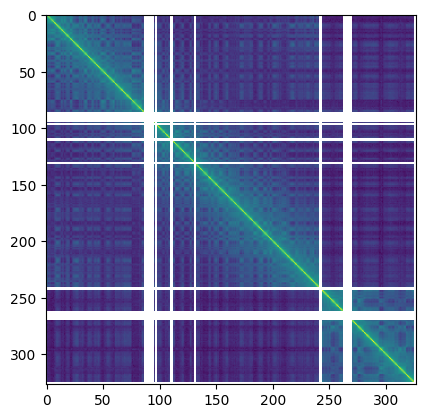

In [9]:
plt.imshow(np.log2(clr.matrix()[:]))

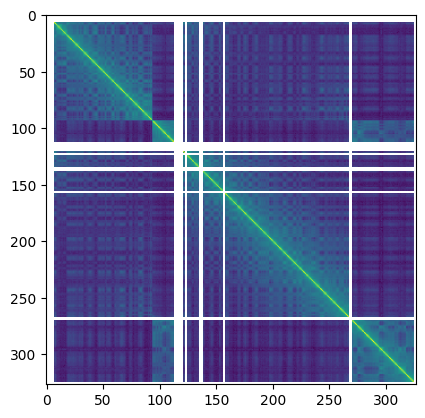

In [10]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [11]:
clr_new.chroms()[:]

,name,length
0,fake_chrom1,120000000
1,fake_chrom2,205450970


In [12]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,fake_chrom1,0,1000000,NaN
1,fake_chrom1,1000000,2000000,NaN
2,fake_chrom1,2000000,3000000,NaN
3,fake_chrom1,3000000,4000000,NaN
4,fake_chrom1,4000000,5000000,NaN
...,...,...,...,...
322,fake_chrom2,201193529,202193529,0.002830
323,fake_chrom2,202193529,203193529,0.003012
324,fake_chrom2,203193529,204193529,0.003727
325,fake_chrom2,204193529,205193529,0.003376


## New view with subset of regions

In [13]:
new_view = hg38_arms.iloc[[0, 3]].reset_index(drop=True).copy()
# Note that we don't create new chromosome names and orientations, they will be retained as were before:
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name
0,chr2,0,94000000,chr2_p
1,chr17,26000000,83257441,chr17_q


In [14]:
rearrange_cooler(clr, new_view, 'test_reordered_subset.cool', new_chrom_col=None, orientation_col=None, assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered_subset.cool


In [15]:
clr_new = cooler.Cooler('test_reordered_subset.cool')

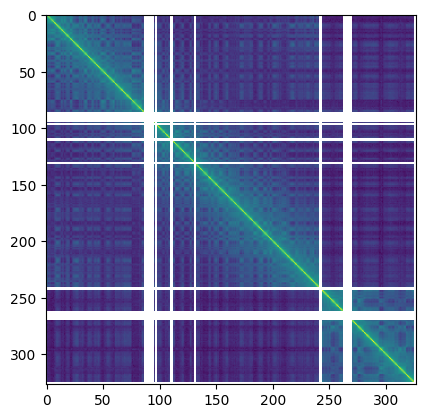

In [16]:
plt.imshow(np.log2(clr.matrix()[:]))

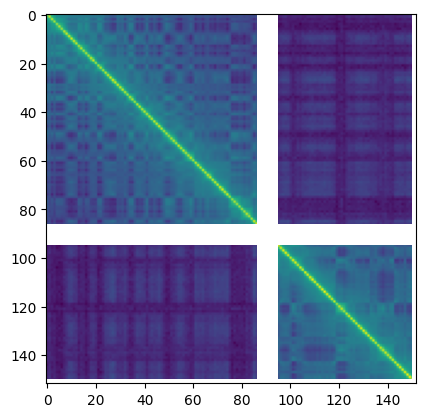

In [17]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [18]:
clr_new.chroms()[:]

,name,length
0,chr2,94000000
1,chr17,57257441


In [19]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728
3,chr2,3000000,4000000,0.001755
4,chr2,4000000,5000000,0.002474
...,...,...,...,...
147,chr17,53000000,54000000,0.002830
148,chr17,54000000,55000000,0.003012
149,chr17,55000000,56000000,0.003727
150,chr17,56000000,57000000,0.003376


In [20]:
clr_new.info['genome-assembly']

'hg38_custom'